# Estimanting Covariance and Expected Returns

We've backtested CW and EW Portfolios and they each have unique positions in industrial implementations.

CapWeighted portfolios are the overall average and hence the de-facto industry standard. They are very inexpensive to implement and feature very low turnover. In many ways, they are the default go-to implementation choice for many investors.

However, we've seen that they suffer from some disadvantages, so there is some room for improvement.

EW are the most obvious improvement because they are the only other technique we are going to look at (other than CW) that requires no estimation of either covariance or expected returns. We've already backtested those and we've seen how easy they are to build.

We'll now move on the more sophisticated portfolio construction techniques, but they will get us involved in the estimation game, something we've avoided so far ... so let's start by pulling in the data we need and start with the CW and EW portfolios, since they are the baseline portfolios.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

### Loading Data

In [3]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype == "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype == "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype == "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_returns(weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios Monthly Returns
    """
    return get_ind_file("returns", weighting=weighting, n_inds=n_inds)

def get_ind_nfirms(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms", n_inds=n_inds)

def get_ind_size(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size", n_inds=n_inds)


def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_nfirms(n_inds=n_inds)
    ind_size = get_ind_size(n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    #else
    return ind_mktcap

def get_fff_returns():
    """
    Load the Fama-French Research Factor Monthly Dataset
    Mkt-Rf = market - risk free
    SMB = Small - Big
    HML = Hight - Low
    """
    rets = pd.read_csv("./data/F-F_Research_Data_Factors_m.csv",
                       header=0, index_col=0, na_values=-99.99)/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    return rets

In [23]:
ind_rets = get_ind_returns(weighting='vw', n_inds = 30)['1997':'2018']

ind_mcap = get_ind_market_caps(30, weights=True)['1997':'2018']

### backtest

In [5]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()


def backtest_ws(r, estimation_window=60, weighting=weight_ew, verbose=False, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert List of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

### Summary Stats

In [6]:
import scipy.stats
from scipy.stats import norm
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})



def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

                         
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol



def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")



def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))
    
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

# 01 - Builing an EW and a CW portifolios

In [24]:
ewr = backtest_ws(ind_rets, estimation_window=36, weighting=weight_ew)
cwr = backtest_ws(ind_rets, estimation_window=36, weighting=weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.064564,0.151274,-0.552933,4.248421,0.070982,0.098269,0.222191,-0.518857


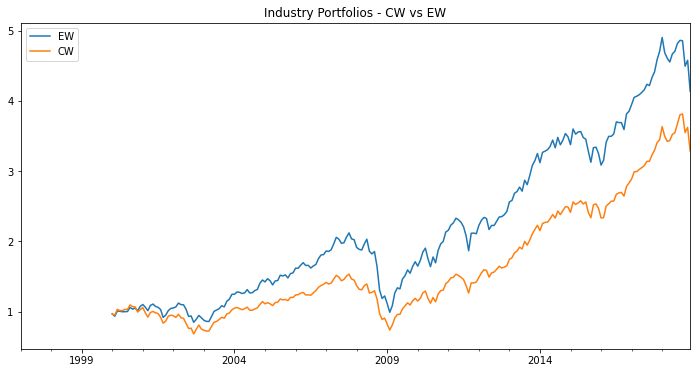

In [8]:
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")

# 02 - Building a tethered EW Portifolio

removing microcap industries , threshold of 1%, max cap-weight = 2x

In [9]:
t_ewr = backtest_ws(ind_rets, estimation_window=36, weighting=weight_ew, cap_weights=ind_mcap, max_cw_mult=2, microcap_threshold=0.01)

In [10]:
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "T_EWR": t_ewr})
summary_stats(btr.dropna())


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.064564,0.151274,-0.552933,4.248421,0.070982,0.098269,0.222191,-0.518857
T_EWR,0.076838,0.140774,-0.649872,4.664374,0.065482,0.093766,0.323653,-0.487413


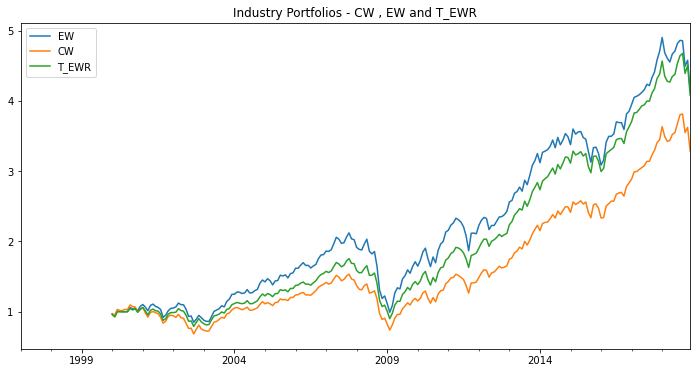

In [11]:
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW , EW and T_EWR")

# 3- Calculating tracking Error

In [25]:
def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())

In [26]:
#ewr and t_ewr
tracking_error(ewr, t_ewr)

0.14837640318931777

In [14]:
#ewr and t_ewr
tracking_error(t_ewr, cwr)

0.1165066134512106

# 4 - Building the Global Minimum Variance Portifolio

In [15]:
from scipy.optimize import minimize

In [16]:
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

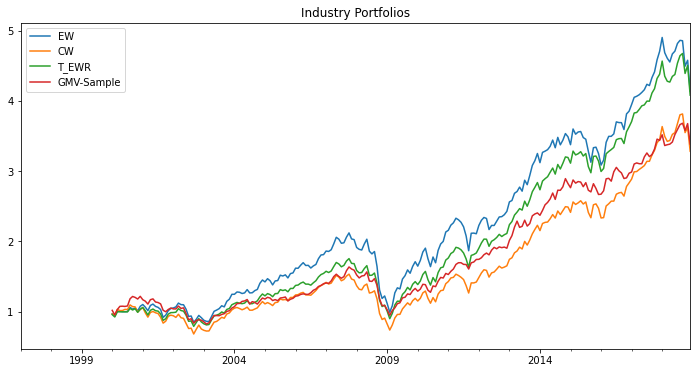

In [18]:
mv_s_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "T_EWR": t_ewr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")

In [19]:
summary_stats(btr.dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.064564,0.151274,-0.552933,4.248421,0.070982,0.098269,0.222191,-0.518857
T_EWR,0.076838,0.140774,-0.649872,4.664374,0.065482,0.093766,0.323653,-0.487413
GMV-Sample,0.066306,0.117410,-0.741088,4.469215,0.055456,0.080583,0.300816,-0.421289


# 04 - Shrinkage

Now, let's try a new estimator - Constant Correlation. The idea is simple, take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$

In [20]:
#import statsmodels.stats.moment_helpers as mh
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
#     mh.corr2cov(ccor, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

In [21]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

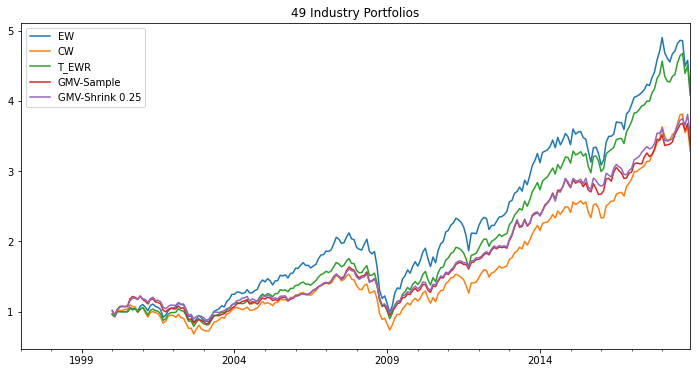

In [28]:
mv_sh_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.25)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "T_EWR": t_ewr, "GMV-Sample": mv_s_r, 'GMV-Shrink 0.25': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")


In [29]:
summary_stats(btr.dropna()) 

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.077614,0.158685,-0.538531,5.317042,0.072485,0.106220,0.291838,-0.532980
CW,0.064564,0.151274,-0.552933,4.248421,0.070982,0.098269,0.222191,-0.518857
T_EWR,0.076838,0.140774,-0.649872,4.664374,0.065482,0.093766,0.323653,-0.487413
GMV-Sample,0.066306,0.117410,-0.741088,4.469215,0.055456,0.080583,0.300816,-0.421289
GMV-Shrink 0.25,0.068467,0.114572,-0.731292,4.264940,0.053884,0.077715,0.326632,-0.393410
